# Import and install libraries

In [ ]:
!pip install yfinance --quiet

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# Prepare Time Series

In [ ]:
data = yf.Ticker('TSLA')
data = data.history(start="2020-12-31", interval='1d', rounding=True)
data = data[['Close']].reset_index()

r = pd.date_range(start=data.Date.min(), end=pd.to_datetime(data.Date.max(), format='%Y-%m-%d'))
data=data.groupby('Date').mean().reindex(r)
data.fillna(method='ffill',inplace=True)
data = data.reset_index().rename({'index':'Date'},axis=1)
data = data.loc[data.Date >= '2021-01-01']
data

,Date,Close
1,2021-01-01,705.67
2,2021-01-02,705.67
3,2021-01-03,705.67
4,2021-01-04,729.77
5,2021-01-05,735.11
...,...,...
260,2021-09-17,759.49
261,2021-09-18,759.49
262,2021-09-19,759.49
263,2021-09-20,730.17


In [ ]:
def scale_tesla(data):
  return (data - 550)/(900-550)
def scale_tesla_inv(data):
  return data*(900-550) + 550

In [ ]:
data['Close'] = data.Close.apply(scale_tesla)

In [ ]:
#scaler  = MinMaxScaler()
#scaler.fit(data.Close.to_numpy()[:,np.newaxis])
#data['Close'] = scaler.transform(data.Close.to_numpy()[:,np.newaxis])
data.head()

,Date,Close
1,2021-01-01,0.444771
2,2021-01-02,0.444771
3,2021-01-03,0.444771
4,2021-01-04,0.513629
5,2021-01-05,0.528886


In [ ]:
elon = pd.read_csv('/content/drive/MyDrive/Assignments/Stock price/Models_TS/elon_sent_2021.csv',index_col=0)
reddit = pd.read_csv('/content/drive/MyDrive/Assignments/Stock price/Models_TS/reddit_sent_2021.csv',index_col=0)
reddit.fillna(0,inplace=True)
news = pd.read_csv('/content/drive/MyDrive/Assignments/Stock price/Models_TS/news_sent_2021.csv',index_col=0)
news['date'] = pd.to_datetime(news.date,format='%d/%m/%Y')

In [ ]:
print(data.shape,data.Date.min(),data.Date.max())
print(elon.shape,elon.date.min(),elon.date.max())
print(reddit.shape,reddit.date.min(),reddit.date.max())
print(news.shape,news.date.min(),news.date.max())

(264, 2) 2021-01-01 00:00:00 2021-09-21 00:00:00
(262, 2) 2021-01-01 2021-09-19
(259, 2) 2021-01-01 2021-09-16
(262, 2) 2021-01-01 00:00:00 2021-09-19 00:00:00


In [ ]:
data = data[:259]
elon = elon[:259]
reddit = reddit[:259]
news =  news[:259]

In [ ]:
print(data.shape,data.Date.min(),data.Date.max())
print(elon.shape,elon.date.min(),elon.date.max())
print(reddit.shape,reddit.date.min(),reddit.date.max())
print(news.shape,news.date.min(),news.date.max())

(259, 2) 2021-01-01 00:00:00 2021-09-16 00:00:00
(259, 2) 2021-01-01 2021-09-16
(259, 2) 2021-01-01 2021-09-16
(259, 2) 2021-01-01 00:00:00 2021-09-16 00:00:00


In [ ]:
data = pd.DataFrame({'stock':data.Close.values,'elon':elon.sentiment.values,'reddit':reddit.sentiment.values,'news':news.sentiment.values})
data

,stock,elon,reddit,news
0,0.444771,0.506010,0.000000,0.366396
1,0.444771,0.397090,0.000000,0.149246
2,0.444771,0.375703,0.000000,0.248707
3,0.513629,-0.036051,0.000000,-0.233317
4,0.528886,0.067608,0.000000,0.020349
...,...,...,...,...
254,0.532200,0.069704,-0.026345,0.237941
255,0.551429,-0.072337,0.011645,0.765736
256,0.555686,0.002163,-0.081138,-0.156679
257,0.588086,0.310431,-0.069122,-0.293066


In [ ]:
data.isna().sum()

stock     0
elon      0
reddit    0
news      0
dtype: int64

In [ ]:
scaler  = MinMaxScaler()
scaler.fit(data.iloc[:,1:].to_numpy())
data.iloc[:,1:] = scaler.transform(data.iloc[:,1:].to_numpy())

In [ ]:
data

,stock,elon,reddit,news
0,0.444771,0.721979,0.452021,0.702044
1,0.444771,0.659272,0.452021,0.587116
2,0.444771,0.646959,0.452021,0.639756
3,0.513629,0.409908,0.452021,0.384641
4,0.528886,0.469586,0.452021,0.518895
...,...,...,...,...
254,0.532200,0.470792,0.330724,0.634058
255,0.551429,0.389017,0.505636,0.913398
256,0.555686,0.431908,0.078441,0.425202
257,0.588086,0.609382,0.133764,0.353018


# Create windows for tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(data)

dataset = dataset.window(28, shift=1, drop_remainder=True)

dataset = dataset.flat_map(lambda w: w.batch(28))

dataset = dataset.map(lambda w: (w[:21], w[21:,0]))

In [ ]:
size = sum(1 for X,y in dataset)
for X, y in dataset.take(1):
  print("Input:", X.numpy(), "Target:", y.numpy())

Input: [[0.44477143 0.72197878 0.452021   0.70204426]
 [0.44477143 0.65927193 0.452021   0.58711558]
 [0.44477143 0.64695935 0.452021   0.63975636]
 [0.51362857 0.40990793 0.452021   0.38464059]
 [0.52888571 0.46958577 0.452021   0.5188954 ]
 [0.58851429 0.4701776  0.452021   0.32040764]
 [0.76011429 0.47076943 0.452021   0.50533557]
 [0.94291429 0.58243387 0.452021   0.60502952]
 [0.94291429 0.62863436 0.452021   0.60442066]
 [0.94291429 0.45548311 0.452021   0.5059418 ]
 [0.74625714 0.57413146 0.452021   0.45069572]
 [0.85554286 0.59005811 0.452021   0.6089151 ]
 [0.86974286 0.47683708 0.452021   0.47929249]
 [0.84285714 0.36361604 0.452021   0.41527245]
 [0.78902857 0.63001946 0.452021   0.5096471 ]
 [0.78902857 0.56157798 0.452021   0.94105479]
 [0.78902857 0.99146735 0.452021   0.72642916]
 [0.78902857 0.63290191 0.452021   0.0086692 ]
 [0.84157143 0.81645095 0.452021   0.0086692 ]
 [0.85842857 1.         0.452021   0.18253416]
 [0.84282857 0.60761825 0.452021   0.35639912]] Targe

In [ ]:
train_dataset = dataset.take(size).shuffle(10).batch(8).prefetch(1)
test_dataset = dataset.skip(size-7).batch(8).prefetch(1)

In [ ]:
for i,j in test_dataset:
  print(i,j)

tf.Tensor(
[[[0.47762857 0.59172947 0.51151479 0.01280433]
  [0.47762857 0.49703976 0.47893533 0.5202217 ]
  [0.38905714 0.99135625 0.16831186 0.44170826]
  [0.3306     0.9824216  0.14537593 0.44987195]
  [0.39711429 0.54655532 0.33530191 0.41112763]
  [0.35277143 0.95511286 0.36936832 0.61868594]
  [0.37217143 0.48108422 1.         0.48399122]
  [0.37217143 0.68587495 0.24470579 0.48399122]
  [0.37217143 0.57799265 0.39711424 0.62959127]
  [0.44657143 0.47011035 0.2603303  0.62959127]
  [0.45282857 0.61038944 0.41849211 0.64609504]
  [0.46057143 0.5828189  0.48530384 0.46398261]
  [0.43188571 0.53718406 0.37104129 0.25046064]
  [0.46262857 0.67840122 0.65321072 0.48324325]
  [0.46262857 0.46205261 0.17870315 0.44847029]
  [0.46262857 0.52849103 0.12589763 0.0073266 ]
  [0.51688571 0.62494266 0.42756703 0.57147175]
  [0.53062857 0.39952733 0.23371142 0.27300218]
  [0.52597143 0.46743511 0.55351344 0.59769174]
  [0.52111429 0.56625441 0.44557085 0.25832078]
  [0.52448571 0.44921049 0.22

# Model

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from keras.layers import Input, Flatten, Dense, Dropout, LSTM, GRU
from tensorflow.keras import callbacks

In [ ]:
model1 = Sequential([
    Input(shape=(21,4)),
    #Model layers
    LSTM(60, return_sequences=True),
    LSTM(60, return_sequences=True),
    Flatten(),
    Dense(60, activation="relu"),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.4),
    Dense(7)
])

model2 = Sequential([
    Input(shape=(21,4)),
    #Model layers
    LSTM(60, return_sequences=True),
    Flatten(),
    Dense(60, activation="relu"),
    Dense(16, activation="relu"),
    Dense(7)
])

model3 = Sequential([
    Input(shape=(21,4)),
    #Model layers
    LSTM(128, return_sequences=True),
    Flatten(),
    Dense(60, activation="relu"),
    Dense(16, activation="relu"),
    Dense(7)
])

model4 = Sequential([
    Input(shape=(21,4)),
    #Model layers
    LSTM(80, return_sequences=True),
    Flatten(),
    Dense(600, activation="relu"),
    Dense(120, activation="relu"),
    Dense(16, activation="relu"),
    Dense(7)
])

model5 = Sequential([
    Input(shape=(21,4)),
    #Model layers
    LSTM(80, return_sequences=True),
    GRU(80, return_sequences=True),
    Flatten(),
    Dense(600, activation="relu"),
    Dense(120, activation="relu"),
    Dense(16, activation="relu"),
    Dense(7)
])

model6 = Sequential([
    Input(shape=(21,4)),
    #Model layers
    GRU(80, return_sequences=True),
    Flatten(),
    Dense(600, activation="relu"),
    Dense(120, activation="relu"),
    Dense(16, activation="relu"),
    Dense(7)
])

model = model6

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 21, 80)            20640     
_________________________________________________________________
flatten_17 (Flatten)         (None, 1680)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 600)               1008600   
_________________________________________________________________
dense_63 (Dense)             (None, 120)               72120     
_________________________________________________________________
dense_64 (Dense)             (None, 16)                1936      
_________________________________________________________________
dense_65 (Dense)             (None, 7)                 119       
Total params: 1,103,415
Trainable params: 1,103,415
Non-trainable params: 0
___________________________________________

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.Huber(),
    metrics=['mae'],
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=100, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor="loss",
)

reduceLR = callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=25
)

In [ ]:
history = model.fit(
    train_dataset,
    batch_size = 8,
    epochs=500,
    callbacks=[early_stopping, reduceLR]
)

history_frame = pd.DataFrame(history.history)

Epoch 1/500
29/29 [==============================] - 3s 10ms/step - loss: 0.0567 - mae: 0.2487
Epoch 2/500
29/29 [==============================] - 0s 9ms/step - loss: 0.0300 - mae: 0.1926
Epoch 3/500
29/29 [==============================] - 0s 9ms/step - loss: 0.0251 - mae: 0.1714
Epoch 4/500
29/29 [==============================] - 0s 10ms/step - loss: 0.0217 - mae: 0.1590
Epoch 5/500
29/29 [==============================] - 0s 9ms/step - loss: 0.0202 - mae: 0.1650
Epoch 6/500
29/29 [==============================] - 0s 9ms/step - loss: 0.0203 - mae: 0.1493
Epoch 7/500
29/29 [==============================] - 0s 10ms/step - loss: 0.0266 - mae: 0.1664
Epoch 8/500
29/29 [==============================] - 0s 9ms/step - loss: 0.0132 - mae: 0.1353
Epoch 9/500
29/29 [==============================] - 0s 10ms/step - loss: 0.0245 - mae: 0.1799
Epoch 10/500
29/29 [==============================] - 0s 9ms/step - loss: 0.0164 - mae: 0.1541
Epoch 11/500
29/29 [==============================] - 0

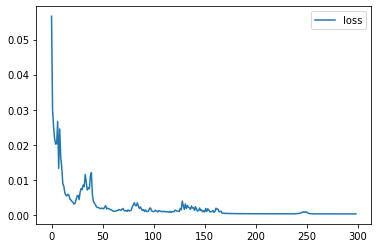

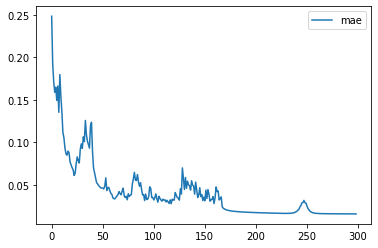

In [ ]:
history_frame.loc[:, ['loss']].plot()
history_frame.loc[:, ['mae']].plot()

In [ ]:
model.evaluate(test_dataset)

1/1 [==============================] - 1s 579ms/step - loss: 1.2433e-04 - mae: 0.0120


[0.00012432815856300294, 0.011992981657385826]

In [ ]:
predictions = model.predict(test_dataset)
predictions = scale_tesla_inv(predictions)
predictions

array([[734.4552 , 738.02234, 734.0108 , 743.52344, 752.8542 , 746.6237 ,
        748.0897 ],
       [730.7328 , 745.4376 , 745.6793 , 750.191  , 743.58813, 738.19885,
        739.594  ],
       [736.209  , 752.4539 , 755.5278 , 754.53864, 739.1384 , 736.03973,
        735.63293],
       [756.2965 , 748.65894, 750.53   , 742.8932 , 738.6454 , 741.7014 ,
        734.9434 ],
       [752.0996 , 748.06824, 746.5185 , 737.91833, 740.84424, 739.81494,
        731.6907 ],
       [755.14014, 734.5677 , 735.91833, 741.3956 , 743.20654, 748.7133 ,
        748.0439 ],
       [744.93567, 734.8906 , 737.6602 , 746.3336 , 751.4198 , 756.48364,
        756.97626]], dtype=float32)

In [ ]:
for x,y in test_dataset.take(1):
  original = scale_tesla_inv(y.numpy())
  print(original)

[[733.57 733.57 733.57 752.92 753.87 754.86 736.27]
 [733.57 733.57 752.92 753.87 754.86 736.27 736.27]
 [733.57 752.92 753.87 754.86 736.27 736.27 736.27]
 [752.92 753.87 754.86 736.27 736.27 736.27 743.  ]
 [753.87 754.86 736.27 736.27 736.27 743.   744.49]
 [754.86 736.27 736.27 736.27 743.   744.49 755.83]
 [736.27 736.27 736.27 743.   744.49 755.83 756.99]]


In [ ]:
 err = pd.DataFrame(original - predictions)
 err

,0,1,2,3,4,5,6
0,-0.885200,-4.452339,-0.440803,9.396562,1.015813,8.236282,-11.819722
1,2.837212,-11.867622,7.240679,3.679021,11.271865,-1.928853,-3.323994
2,-2.638984,0.466082,-1.657771,0.321365,-2.868428,0.230266,0.637065
3,-3.376509,5.211064,4.329971,-6.623188,-2.375386,-5.431416,8.056580
4,1.770391,6.791763,-10.248494,-1.648335,-4.574238,3.185059,12.799326
5,-0.280137,1.702312,0.351665,-5.125630,-0.206543,-4.223318,7.786116
6,-8.665669,1.379375,-1.390217,-3.333618,-6.929800,-0.653643,0.013743


In [ ]:
err.mean(axis = 1)

0    0.150085
1    1.129758
2   -0.787201
3   -0.029841
4    1.153639
5    0.000638
6   -2.797118
dtype: float64

In [ ]:
err.std(axis = 1)

0    7.274533
1    7.612957
2    1.548220
3    5.791031
4    7.556297
5    4.240180
6    3.735520
dtype: float64

In [ ]:
err.apply(abs).mean(axis=0)

0    2.922015
1    4.552937
2    3.665657
3    4.303960
4    4.177439
5    3.412691
6    6.348078
dtype: float64

In [ ]:
model.save_weights('GRU_model_weights.h5')

In [ ]:
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['scaler.save']